This notebook replicates Jake VanderPlas' [post](http://jakevdp.github.io/blog/2018/09/13/waiting-time-paradox/) on the bus paradox. 

# Background

The bus paradox is a special case of the [inspection paradox](https://towardsdatascience.com/the-inspection-paradox-is-everywhere-2ef1c2e9d709), which – as VanderPlas succinctly summarises – occurs whenever the probability of observing a quantity is related to the quantity being observed. For example: if you sample random students on campus and ask them about the size of their classes you'll probably get a larger number than if you asked the collge administrator, because you're likely to oversample students from large classes. Similarly, you are more likely to arrive at a bus stop during a longer waiting time simply because the waiting time is longer. 

However, the waiting time paradox claims not only that the experienced waiting time is longer than the average waiting time, but that it is twice as long. 

# Simulating wait times

In [136]:
# Simulate bus arrivals

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

from scipy.stats import poisson
from scipy.stats import norm

from waiting_time_paradox.toolbox import simulate_bus_arrivals
from waiting_time_paradox.toolbox import simulate_wait_times

In [31]:
# Create bus arrival times and check that frequency is about tau

bus_arrival_times = simulate_bus_arrivals(n=1000000, tau=10, rseed=231286)
intervals = np.diff(bus_arrival_times)
intervals.mean()

9.99999909406286

In [34]:
# Calculate passenger waiting times

wait_times = simulate_wait_times(bus_arrival_times)
wait_times.mean()

10.006779581581114

This is in line with the paradox: if buses arrive every 10 minutes on average, the the average wait time is not 5 minutes, but 10 mintues.

# Digging deeper

To model the above result analytically, let's model the process we generated to calculate waiting times and then derive the expected waiting time.

For a start, we can write the expected value of intervals $T$ between bus arrivals as

$$ E(T) = \int_{0}^{\infty} Tp(T)dT $$.

In the simulation above, we set $E(T) = \tau = 10$ minutes.

What we're after, however, is the expected value of the waiting time for a rider who arrives at the bus stop. To get this, we first model the distribution of experienced waiting times for customers, and then recognise that the expected value of the waiting time is half the expected value for the experienced waiting time.

From the inspection paradox, we know that the experienced waiting time depends on the actual intervals between buses, $p(T)$ as well as on the length of the intervals, $T$. So we can write

$$ p_{exp}(T) \propto Tp(T)$$.

Substitute the constant of proportionality for the proportional sign seemed obvious for jvdp, but was less so for me, so I'm gonna back up and explain, based on [this](https://davidrosenberg.github.io/mlcourse/Notes/proportionality.pdf) super helpful resource.

If $ p_{exp}(T) \propto Tp(T)$, then we know that there exists a constant of proportionality $k$ such that

$$ p_{exp}(T) = kTp(T)$$.

Because $p_{exp}(T)$ is a density, we have $\int_0^\infty p_{exp}(T)dT = 1$, which means that 

$$\int_0^\infty kTp(T)dT = 1$$
$$k\int_0^\infty Tp(T)dT = 1$$
$$k = \left[\int_0^\infty kTp(T)dT\right]^{-1}$$

Using this in our expression above, we get 

$$p_{exp}(T) = \frac{Tp(T)}{\int_0^\infty Tp(T)dT}$$.

And using the definition of $E(T)$ above, this simplifies to

$$p_{exp}(T) = \frac{Tp(T)}{E(T)}$$.

To find the expected waiting time $E(W)$, the final step is use the fact that the expected value for the observed interval is half the expected interval (if riders experience buses at arriving every 20 minutes, then their expected waiting time is 10 minutes). We can thus write:

$$E(W) = \frac{1}{2} E_{exp}(T) = \frac{1}{2} \int_{0}^{\infty} Tp_{exp}(T)dT$$.

Using our expression from above and rewriting gives

$$
E(W) = \frac{1}{2} \int_{0}^{\infty} T\frac{Tp(T)}{E(T)}dT
E(W) = \frac{1}{2E(T)} \int_{0}^{\infty} T^2p(T)dT
E(W) =\frac{E(T^2)}{2E(T)}
$$.

What we now need to do is to find a form for $p(T)$ and compute our integrals.

# Choosing p(T)

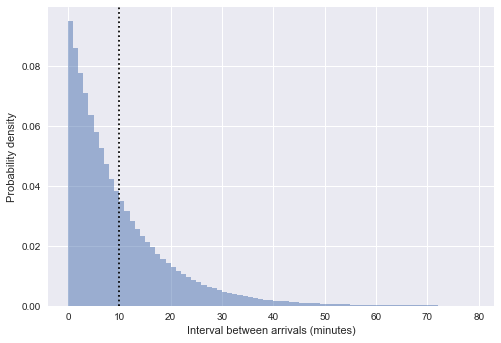

In [4]:
# Plot distribution of simulated intervals

plt.hist(intervals, bins=np.arange(80), alpha=0.5, density=True)
plt.axvline(intervals.mean(), color='black', linestyle='dotted')
plt.xlabel('Interval between arrivals (minutes)')
plt.ylabel('Probability density');

The distribution of intervals is clearly exponential. The original post describes in some more detail why this was to be expected given that we sampled arrival times from a uniform distribution. The short answer is: random selection from a uniform distribution approximates a poisson process, and the distribution of intervals of a poisson process is exponential. Let's thus check whether our arrival times do indeed follow a poisson distribution.

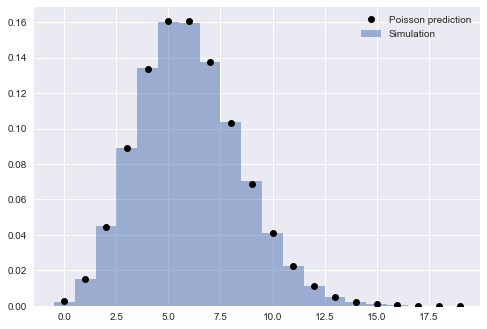

In [5]:
# Count number of arrivals for each 1-hour interval

binsize = 60
binned_counts = np.bincount((np.sort(bus_arrival_times) // binsize).astype('int'))

# Plot results and compare with poisson distribution

x = np.arange(20)
tau = 10
mu = binsize / tau
plt.hist(binned_counts, bins=x-0.5, density=True, alpha=0.5, label='Simulation',)
plt.plot(x, poisson.pmf(x, mu), 'ok', label='Poisson prediction')
plt.legend();

It's clear that the poisson distribution approximates our distribution of simulated arrivals very well. This means that we can write the probability distribution of our intervals as ...

...

jvdp gets $p(T) = \frac{1}{\tau}e^{-T/\tau}$

I can't see where this is coming from. Following the logic of [this](https://nicolewhite.github.io/2015/05/23/understanding-waiting-times.html) post, I get $p(T) = -e^{T/\tau}$

# Waiting times in reality

In [6]:
# Load data
df = pd.read_csv('./data/arrival_times.csv')
df = df.dropna(axis=0, how='any')
df.head()

,OPD_DATE,VEHICLE_ID,RTE,DIR,TRIP_ID,STOP_ID,STOP_NAME,SCH_STOP_TM,ACT_STOP_TM
0,2016-03-26,6201,673,S,30908177,431,3RD AVE & PIKE ST (431),01:11:57,01:13:19
1,2016-03-26,6201,673,S,30908033,431,3RD AVE & PIKE ST (431),23:19:57,23:16:13
2,2016-03-26,6201,673,S,30908028,431,3RD AVE & PIKE ST (431),21:19:57,21:18:46
3,2016-03-26,6201,673,S,30908019,431,3RD AVE & PIKE ST (431),19:04:57,19:01:49
4,2016-03-26,6201,673,S,30908252,431,3RD AVE & PIKE ST (431),16:42:57,16:42:39


### Data cleanup

In [7]:
# Combine time and data into single timestamp
df['actual'] = pd.to_datetime(df['OPD_DATE'] + ' ' + df['ACT_STOP_TM'])
df['scheduled'] = pd.to_datetime(df['OPD_DATE'] + ' ' + df['SCH_STOP_TM'])

# Calculate dalay in minutes, adjusting actual day when actual and scheduled span midnight
minute = np.timedelta64(1, 'm')
hour = 60 * minute
diff_hrs = (df['actual'] - df['scheduled']) / hour
df.loc[diff_hrs < -22, 'actual'] += 2 * hour
df.loc[diff_hrs > 22, 'actual'] -= 2 * hour
df['minutes_late'] = (df['actual'] - df['scheduled']) / minute

# Map internal route codes to external route letters
df['route'] = df['RTE'].replace({673: 'C', 674: 'D', 675: 'E'}).astype('category')
df['direction'] = df['DIR'].replace({'N': 'northbound', 'S': 'southbound'}).astype('category')

# Extract useful columns
df = df[['route', 'direction', 'scheduled', 'actual', 'minutes_late']]

df.head()

,route,direction,scheduled,actual,minutes_late
0,C,southbound,2016-03-26 01:11:57,2016-03-26 01:13:19,1.366667
1,C,southbound,2016-03-26 23:19:57,2016-03-26 23:16:13,-3.733333
2,C,southbound,2016-03-26 21:19:57,2016-03-26 21:18:46,-1.183333
3,C,southbound,2016-03-26 19:04:57,2016-03-26 19:01:49,-3.133333
4,C,southbound,2016-03-26 16:42:57,2016-03-26 16:42:39,-0.300000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38917 entries, 0 to 39156
Data columns (total 5 columns):
route           38917 non-null category
direction       38917 non-null category
scheduled       38917 non-null datetime64[ns]
actual          38917 non-null datetime64[ns]
minutes_late    38917 non-null float64
dtypes: category(2), datetime64[ns](2), float64(1)
memory usage: 1.3 MB


## How late are buses?

We can look at the direction of each route separately to get a sense of the distribution of delays. We can't know this from looking at the data, but the routes are such that the southbound trip for C, and the northbound trip for D and E are near the beginning of the line (i.e. C runs from north to south and back to noth). As jvdp notes, we'd expect buses to keep more closely to their schedules early in the trip, which is precisely what we can see, which is pretty cool!

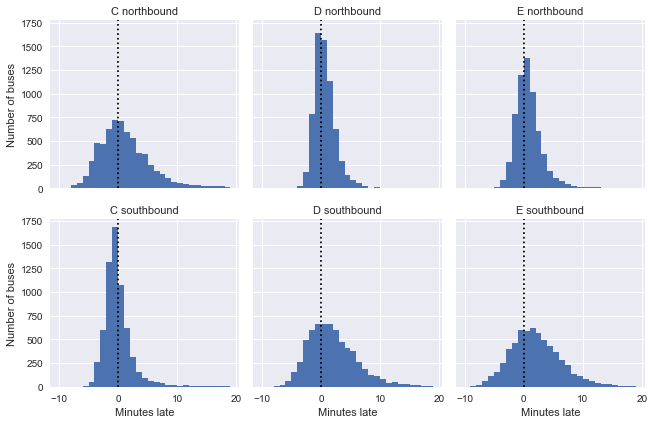

In [9]:
g = sns.FacetGrid(df, row='direction', col='route')
g.map(plt.hist, 'minutes_late', bins=np.arange(-10, 20))
for ax in g.axes.flat:
    ax.axvline(0, color='k', linestyle='dotted')
g.set_titles('{col_name} {row_name}')
g.set_axis_labels('Minutes late', 'Number of buses');

## Scheduled and observed arrival intervals

In [10]:
# Calculate actual and scheduled intervals

def compute_interval(series):
    minute = np.timedelta64(1, 'm')
    return series.sort_values().diff() / minute

grouped = df.groupby(['route', 'direction'])
df['actual_interval'] = grouped['actual'].transform(compute_interval)
df['scheduled_interval'] = grouped['scheduled'].transform(compute_interval)

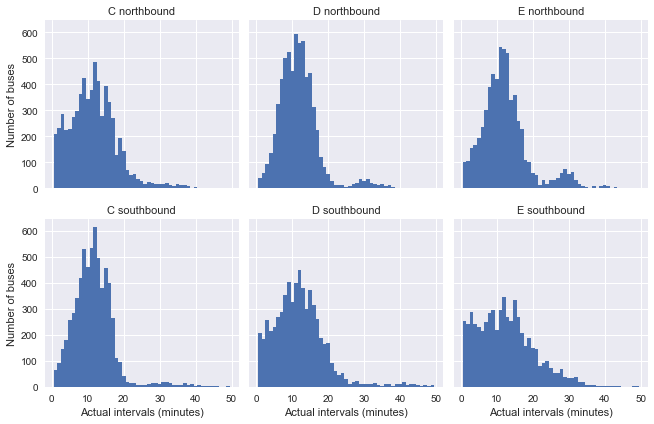

In [11]:
# Plot actual intervals

g = sns.FacetGrid(df, row='direction', col='route')
g.map(plt.hist, 'actual_interval', bins=np.arange(50)+0.5)
g.set_titles('{col_name} {row_name}')
g.set_axis_labels('Actual intervals (minutes)', 'Number of buses');

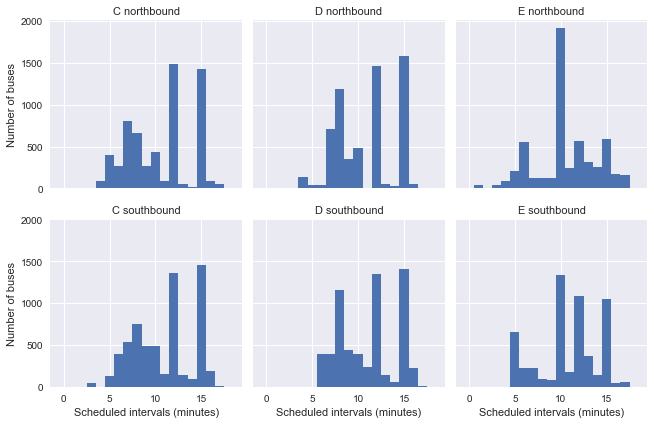

In [12]:
# Plot scheduled intervals

g = sns.FacetGrid(df, row='direction', col='route')
g.map(plt.hist, 'scheduled_interval', bins=np.arange(20)-0.5)
g.set_titles('{col_name} {row_name}')
g.set_axis_labels('Scheduled intervals (minutes)', 'Number of buses');

While actual intervals are clearly not distributed exponentially, the plot of scheduled intervals shows that this might be the case because there are a variety of different scheduled intervals (e.g. it's not the case that all buses are scheduled to arrive in 10 minute intervals).

Instead, jvdp proposes a clever workaround: group arrivals by route, direction, and scheduled interval, and then stack these observations together as if they happened in sequence. This preserves the properties of the data, while giving us a situation analogous to our simulation above: a series of buses scheduled to arrive at constant intervals.

In [13]:
# Check for most frequent intervals

df['scheduled_interval'].value_counts().head(3)

15.0    7367
12.0    7062
10.0    4879
Name: scheduled_interval, dtype: int64

In [133]:
def stacked_sequence(data):
    # Sort by scheduled arrival time
    data = data.sort_values('scheduled')
    
    # Restack data and compute needed variables
    data['scheduled'] = data['scheduled_interval'].cumsum()
    data['actual'] = data['scheduled'] + data['minutes_late']
    data['actual_interval'] = data['actual'].diff()
    return data

subset = df[df['scheduled_interval'].isin(['10', '15'])]
grouped = subset.groupby(['route', 'direction', 'scheduled_interval'])
sequenced = grouped.apply(stacked_sequence).reset_index(drop=True)
sequenced.head()

,route,direction,scheduled,actual,minutes_late,actual_interval,scheduled_interval
0,C,northbound,10.0,12.400000,2.400000,NaN,10.0
1,C,northbound,20.0,27.150000,7.150000,14.750000,10.0
2,C,northbound,30.0,26.966667,-3.033333,-0.183333,10.0
3,C,northbound,40.0,35.516667,-4.483333,8.550000,10.0
4,C,northbound,50.0,53.583333,3.583333,18.066667,10.0


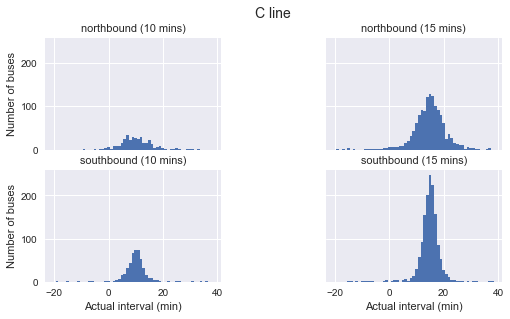

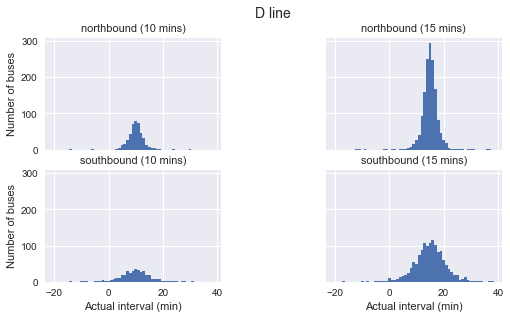

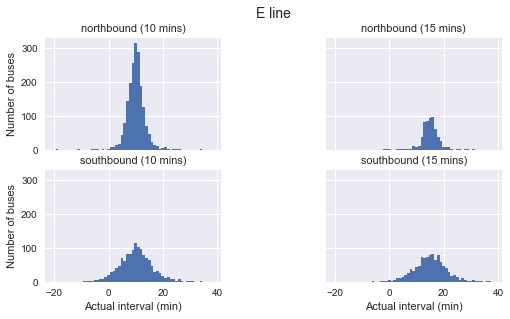

In [134]:
for route in ['C', 'D', 'E']:
    data = sequenced.query(f"route == '{route}'")
    g = sns.FacetGrid(data, row='direction', col='scheduled_interval')
    g.map(plt.hist, 'actual_interval', bins=np.arange(-20, 40)-0.5)
    g.set_titles('{row_name} ({col_name:.0f} mins)')
    g.set_axis_labels('Actual interval (min)', 'Number of buses')
    g.fig.set_size_inches(8, 4)
    g.fig.suptitle(f'{route} line', y=1.05, fontsize=14)

It's very clear that arrival intervals do not follow an exponential distribution. Instead, they are almost perfectly normal and peak near the point of their scheduled interval time.

## Simulate waiting times

In [137]:
grouped = sequenced.groupby(['route', 'direction', 'scheduled_interval'])
sims = grouped['actual'].apply(simulate_wait_times)
sims.apply(lambda times: "{0:.1f} +/- {1:.1f}".format(times.mean(), times.std()))

route  direction   scheduled_interval
C      northbound  10.0                   24.8 +/- 150.5
                   15.0                    12.9 +/- 73.2
       southbound  10.0                      6.2 +/- 6.0
                   15.0                    10.2 +/- 49.5
D      northbound  10.0                      5.9 +/- 6.7
                   15.0                      7.9 +/- 5.3
       southbound  10.0                  238.6 +/- 303.8
                   15.0                  144.5 +/- 252.1
E      northbound  10.0                   27.4 +/- 113.0
                   15.0                      7.9 +/- 4.9
       southbound  10.0                   82.6 +/- 199.6
                   15.0                   54.0 +/- 184.5
Name: actual, dtype: object

# Unsolved issues

1) As indicated above, I still can't see how jvdp gets to $p(T) = \frac{1}{\tau}e^{-T/\tau}$ for the distribution of intervals. Leaving this for now.

2) There is a problem in the code when I include 12 minute intervals. The output below shows len(arrival_times) and max(i) for each subset of the data. For some myserious reason, C northbound 12 mins interval have a customer for which the next bus is 1234, which is the bus after the last bus, which is not possible. I can't figure out how this comes about. So -- after trying to figure this out for an hour now -- I'm gonna leave it for now.

In [69]:
grouped = sequenced.groupby(['route', 'direction', 'scheduled_interval'])
grouped['actual'].apply(simulate_wait_times)

route  direction   scheduled_interval
C      northbound  10.0                    (349, 348)
                   12.0                  (1434, 1434)
                   15.0                  (1377, 1376)
       southbound  10.0                    (483, 482)
                   12.0                  (1312, 1311)
                   15.0                  (1453, 1452)
D      northbound  10.0                    (441, 440)
                   12.0                  (1413, 1412)
                   15.0                  (1507, 1506)
       southbound  10.0                    (395, 394)
                   12.0                  (1300, 1299)
                   15.0                  (1391, 1390)
E      northbound  10.0                  (1869, 1868)
                   12.0                    (516, 515)
                   15.0                    (590, 589)
       southbound  10.0                  (1342, 1341)
                   12.0                  (1087, 1086)
                   15.0                  (10

# Cool stuff picked up while working through this

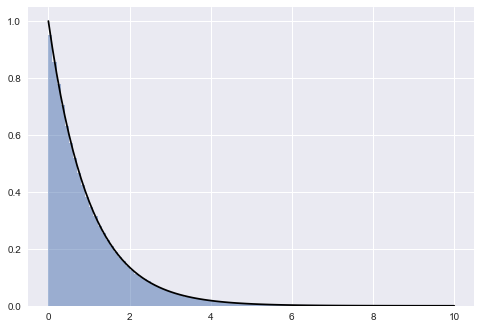

In [139]:
# Simulate arrivals and compare interval distribution to an exponential distribution

import scipy.stats as stats

N = 1000000
x = np.linspace(0, 10, 100)

diffs = np.diff(np.sort(N *np.random.rand(N)))
plt.hist(diffs, bins=x, density=True, alpha=0.5)
plt.plot(x, stats.expon.pdf(x, scale=1), '-k');


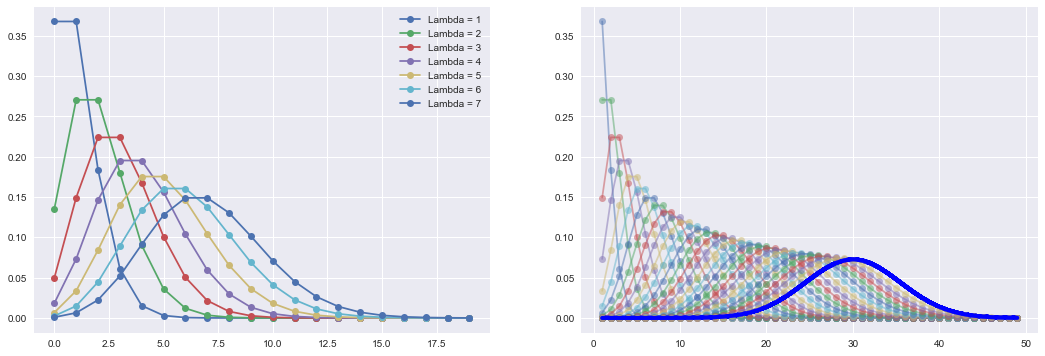

In [140]:
# Playing around with poisson and visualising normal approximation to poisson

fig, ax = plt.subplots(1, 2, figsize=(18,6))

x = np.arange(20)
for l in range(1, 8):
    ax[0].plot(x, poisson.pmf(x, l), '-o', label=f'Lambda = {l}')
    ax[0].legend()

x = np.arange(1, 50)
end = 30
for l in range(1, end):
    ax[1].plot(x, poisson.pmf(x, l), '-o', alpha=0.5, label=f'Lambda ={l}')
    ax[1].plot(x, norm.pdf(x, end, np.sqrt(end)), color='b', linewidth=4)